# Prova final da disciplina Análise Estatística de Dados e Informações - PPCA

Prof. João Gabriel de Moraes Souza

Aluno: Demétrius de Almeida Jubé

# Análise financeira do portifólio de varejistas da área de vestuário do Brasil

Para a nossa análise, serão consideradas as ações de quatro empresas de vestuário que atuam na B3:

| Empresa | Código | Destaque ou perfil corporativo |
|:---|:---:|---|
| Marisa | AMAR3.SA | A maior rede de moda feminina e lingerie do Brasil. É Prêmio Top of Mind na categoria e possui lojas físicas e online. |
| Guararapes | GUAR3.SA | Dona das marcas Riachuelo, Carter's e Midway Financeira. Toda  a confecção da Guararapes abastece as mais de 300 lojas da Riachuelo. |
| Arezzo | ARZZ3.SA | Dona das marcas Arezzo, Schutz e AnaCapri. Também vende produtos da marca Vans. É líder no setor de calçados, bolsas e acessórios femininos. Possui e-commerce e lojas físicas. |
| Lojas Renner | LREN3.SA | Dona das Lojas Renner, Camicado, Realize e Youcom. Possui mais de 600 lojas físicas no Brasil, Uruguai e Argentina, além de e-commerce. |

O índice que será utilizado para comparação será o IBOVESPA (^BVSP), e os objetivos da análise são os seguintes:

* Fazer a análise descritiva dos dados das ações
* Encontrar o portfólio que tenha o melhor Índice de Sharpe, juntamente com a Fronteira Eficiente
* Realizar ANOVA e Testes de Hipóteses
* Executar uma Regressão Linear e encontrar a relação de uma ação específica com o IBOVESPA
* Utilizar um modelo de previsão de Machine Learning para alguma ação

## Análise da performance da carteira

Para realização dos objetivos, vamos montar o ambiente e recuperar os dados que serão analisados:

### Setup do ambiente

Aqui, recuperaremos as bibliotecas que serão utilizadas para carregar e analisar os dados:

In [1]:
import pandas as pd
from pandas_datareader import data
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from scipy import stats
from scipy import optimize

pio.renderers.default = 'notebook_connected'

### Construindo a base de dados com as ações selecionadas

Faremos uma lista das ações que queremos verificar na carteira e buscaremos as informações no Yahoo Finance, utilizando a biblioteca do Panda Datareader para isso.

In [2]:
portfolio = ['AMAR3.SA', 'GUAR3.SA', 'ARZZ3.SA', 'LREN3.SA']
indice = '^BVSP'
acoes = portfolio
acoes.append(indice)
print('Ações que serão pesquisadas:')
acoes

Ações que serão pesquisadas:


['AMAR3.SA', 'GUAR3.SA', 'ARZZ3.SA', 'LREN3.SA', '^BVSP']

In [3]:
acoes_df = pd.DataFrame()
for acao in acoes:
    acoes_df[acao] = data.DataReader(acao,
                                     data_source='yahoo', start='2015-01-01')['Close']

O resultado da pesquisa pode ser verificado abaixo:

In [4]:
acoes_df

,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
Date,,,,,
2015-01-02,13.190909,10.23000,25.850000,12.446208,48512.000000
2015-01-05,13.090909,9.90625,25.040001,12.100207,47517.000000
2015-01-06,12.281818,9.87375,24.549999,12.239591,48001.000000
2015-01-07,12.509090,10.05500,24.799999,12.447848,49463.000000
2015-01-08,12.372727,9.90750,24.680000,12.462606,49943.000000
...,...,...,...,...,...
2022-09-05,2.500000,10.15000,93.309998,26.969999,112203.000000
2022-09-06,2.360000,10.10000,91.660004,26.030001,109764.000000
2022-09-08,2.430000,10.35000,92.250000,26.020000,109916.000000


Por conta da cisão do Pão de Açucar e do Assaí em março de 2021, os dados recuperados estão vindo a partir dessa data.

Será necessário incluir um índice independente na lista, pois a pesquisa coloca como chave de cada registro a data. É possível fazer isso utilizando a função `reset_index` do `DataFrame`. Ao utilizarmos o argumento `inplace=True`, nós garantimos que não há nenhuma perda de dados.

In [5]:
acoes_df.reset_index(inplace=True)
acoes_df

,Date,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
0,2015-01-02,13.190909,10.23000,25.850000,12.446208,48512.000000
1,2015-01-05,13.090909,9.90625,25.040001,12.100207,47517.000000
2,2015-01-06,12.281818,9.87375,24.549999,12.239591,48001.000000
3,2015-01-07,12.509090,10.05500,24.799999,12.447848,49463.000000
4,2015-01-08,12.372727,9.90750,24.680000,12.462606,49943.000000
...,...,...,...,...,...,...
1908,2022-09-05,2.500000,10.15000,93.309998,26.969999,112203.000000
1909,2022-09-06,2.360000,10.10000,91.660004,26.030001,109764.000000
1910,2022-09-08,2.430000,10.35000,92.250000,26.020000,109916.000000
1911,2022-09-09,2.560000,10.58000,93.150002,26.850000,112300.000000


### Visualização dos Dados

A Biblioteca Ploty, do Python, nos permite visualizar, de forma gráfica, os dados que recuperamos. Vamos ver o histórico de preços das ações no decorrer do tempo:

In [7]:
figuraHistorico = px.line(title = 'Histórico do preço das ações')
for i in acoes_df.columns[1:]:
  figuraHistorico.add_scatter(x = acoes_df["Date"] ,y = acoes_df[i], name = i)
figuraHistorico.show()

É possível observar no gráfico o impacto da pandemia de Covid 19 nos papeis. Do portfólio, apenas a Arezzo teve um resultado superior ao da série histórica até aquele momento.

## Taxa de Retorno de Ações

Um dos indicadores que vamos analisar é a taxa de retorno das ações da carteira. Ela basicamente se define como a razão entre o valor atual e o valor anterior. Com os dados que temos, podemos acompanhar a evolução da taxa de retorno comparando o valor de fechamento de um dia com o valor do fechamento do dia anterior. Como há um intervalo de tempo entre esses dois pontos, essa diferença é abrupta, e é possível suavizá-la com o uso do `log`.

A expressão da Valor Esperado da taxa de retorno pode ser descrita assim:

$$ \mathbb{E} [ R_i] = log \left( \frac{P_t}{P_{t-1}} \right) $$

Como temos os dados variando no tempo, é possível fazer esse cálculo para cada registro. Felizmente não será necessário fazer a iteração manual dos dados, pois a  biblioteca `NumPy` tem, através da função `log`, a capacidade de fazer a operação utilizando dois `DataFrame`s, utilizando como argumento os de mesmo índice.

Já temos o `DataFrame` com os dados originais, e só nos falta montar outro com os dados do dia anterior, com o mesmo índice dos dados originais, para poder fazer o cálculo. O artifício que vamos usar para isso é a função `shift` do `DataFrame`. Essa função adiciona uma quantidade de registros no topo do `DataFrame`. Aplicando isso no nosso conjunto de dados, conseguiremos uma cópia dos dados do dia anterior, alinhados com o índice dos nossos dados originais.

O primeiro passo é copiar o `DataFrame` das ações:

In [8]:
dataset = acoes_df.copy()
dataset

,Date,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
0,2015-01-02,13.190909,10.23000,25.850000,12.446208,48512.000000
1,2015-01-05,13.090909,9.90625,25.040001,12.100207,47517.000000
2,2015-01-06,12.281818,9.87375,24.549999,12.239591,48001.000000
3,2015-01-07,12.509090,10.05500,24.799999,12.447848,49463.000000
4,2015-01-08,12.372727,9.90750,24.680000,12.462606,49943.000000
...,...,...,...,...,...,...
1908,2022-09-05,2.500000,10.15000,93.309998,26.969999,112203.000000
1909,2022-09-06,2.360000,10.10000,91.660004,26.030001,109764.000000
1910,2022-09-08,2.430000,10.35000,92.250000,26.020000,109916.000000
1911,2022-09-09,2.560000,10.58000,93.150002,26.850000,112300.000000


Com a cópia, vamos retirar a coluna `Date`, pois ela não será usada no cálculo: 

In [9]:
dataset.drop(labels = ['Date'], axis=1, inplace=True)
dataset

,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
0,13.190909,10.23000,25.850000,12.446208,48512.000000
1,13.090909,9.90625,25.040001,12.100207,47517.000000
2,12.281818,9.87375,24.549999,12.239591,48001.000000
3,12.509090,10.05500,24.799999,12.447848,49463.000000
4,12.372727,9.90750,24.680000,12.462606,49943.000000
...,...,...,...,...,...
1908,2.500000,10.15000,93.309998,26.969999,112203.000000
1909,2.360000,10.10000,91.660004,26.030001,109764.000000
1910,2.430000,10.35000,92.250000,26.020000,109916.000000
1911,2.560000,10.58000,93.150002,26.850000,112300.000000


Realizamos o `shift` para verificar o funcionamento e constatar que a primeira linha foi deslocada:

In [15]:
dataset.shift(1)

,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
0,NaN,NaN,NaN,NaN,NaN
1,13.190909,10.23000,25.850000,12.446208,48512.0
2,13.090909,9.90625,25.040001,12.100207,47517.0
3,12.281818,9.87375,24.549999,12.239591,48001.0
4,12.509090,10.05500,24.799999,12.447848,49463.0
...,...,...,...,...,...
1908,2.500000,9.78000,92.870003,26.700001,110864.0
1909,2.500000,10.15000,93.309998,26.969999,112203.0
1910,2.360000,10.10000,91.660004,26.030001,109764.0
1911,2.430000,10.35000,92.250000,26.020000,109916.0


O resultado das taxas de retorno pode ser visto abaixo:

In [19]:
taxas_retorno = np.log(dataset / dataset.shift(1))
taxas_retorno.fillna(0, inplace=True)
taxas_retorno

,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.007610,-0.032159,-0.031836,-0.028193,-0.020724
2,-0.063798,-0.003286,-0.019763,0.011453,0.010134
3,0.018336,0.018190,0.010132,0.016872,0.030003
4,-0.010961,-0.014778,-0.004850,0.001185,0.009657
...,...,...,...,...,...
1908,0.000000,0.037134,0.004727,0.010062,0.012006
1909,-0.057629,-0.004938,-0.017841,-0.035475,-0.021977
1910,0.029230,0.024451,0.006416,-0.000384,0.001384
1911,0.052116,0.021979,0.009709,0.031400,0.021457


A função `describe` do `DataFrame` pode nos proporcionar várias informações estatísticas importantes sobre as taxas de retorno:

In [20]:
taxas_retorno.describe()

,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
count,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000
mean,-0.000837,0.000026,0.000680,0.000415,0.000411
std,0.038616,0.030018,0.025136,0.024718,0.016273
min,-0.405465,-0.321605,-0.182322,-0.237244,-0.159930
25%,-0.021146,-0.015114,-0.012900,-0.012637,-0.007775
50%,-0.001467,0.000000,0.000000,0.000000,0.000559
75%,0.018272,0.014484,0.013986,0.013628,0.009233
max,0.287061,0.175832,0.153745,0.139762,0.130223


Agora podemos reconstruir os dados de retorno das ações, incluindo a data de cada registro, permitindo a visualização do comportamento do retorno ao longo do tempo. Para isso, podemos selecionar a coluna de data do `DataFrame` original e juntá-lo com a matriz das taxas de retorno. 

In [21]:
dataset_date = acoes_df.copy()
date = dataset_date.filter(["Date"]) 
date

,Date
0,2015-01-02
1,2015-01-05
2,2015-01-06
3,2015-01-07
4,2015-01-08
...,...
1908,2022-09-05
1909,2022-09-06
1910,2022-09-08
1911,2022-09-09


In [22]:
taxas_retorno_date = pd.concat([date, taxas_retorno], axis=1)
taxas_retorno_date

,Date,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
0,2015-01-02,0.000000,0.000000,0.000000,0.000000,0.000000
1,2015-01-05,-0.007610,-0.032159,-0.031836,-0.028193,-0.020724
2,2015-01-06,-0.063798,-0.003286,-0.019763,0.011453,0.010134
3,2015-01-07,0.018336,0.018190,0.010132,0.016872,0.030003
4,2015-01-08,-0.010961,-0.014778,-0.004850,0.001185,0.009657
...,...,...,...,...,...,...
1908,2022-09-05,0.000000,0.037134,0.004727,0.010062,0.012006
1909,2022-09-06,-0.057629,-0.004938,-0.017841,-0.035475,-0.021977
1910,2022-09-08,0.029230,0.024451,0.006416,-0.000384,0.001384
1911,2022-09-09,0.052116,0.021979,0.009709,0.031400,0.021457


E com isso, plotar um gráfico desse histórico:

In [23]:
figuraHistoricoRetorno = px.line(title = 'Histórico de retorno das ações')
for i in taxas_retorno_date.columns[1:]:
  figuraHistoricoRetorno.add_scatter(x = taxas_retorno_date["Date"] ,y = taxas_retorno_date[i], name = i)
figuraHistoricoRetorno.show()

### Covariância das taxas de retorno

O `DataFrame` nos permite verificar um dados interessante também: a *covariância* entre duas ações. No mercado financeiro, esse dado pode ser usado para avaliar como o  comportamento do preço de um ativo influencia no aumento ou diminuição de outro. No nosso caso, temos ao resultado abaixo: 

In [25]:
taxas_retorno.cov()

,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
AMAR3.SA,0.001491,0.000668,0.000430,0.000517,0.000327
GUAR3.SA,0.000668,0.000901,0.000351,0.000438,0.000275
ARZZ3.SA,0.000430,0.000351,0.000632,0.000342,0.000228
LREN3.SA,0.000517,0.000438,0.000342,0.000611,0.000276
^BVSP,0.000327,0.000275,0.000228,0.000276,0.000265


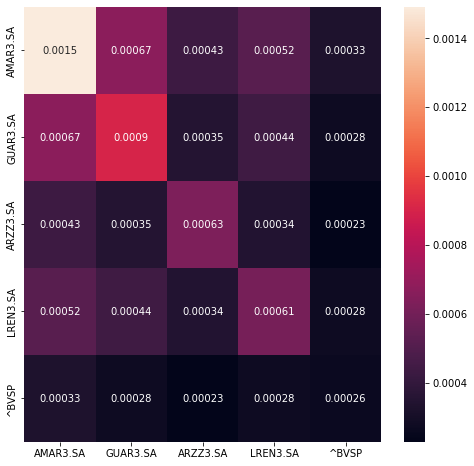

In [27]:
plt.figure(figsize=(8,8))
sns.heatmap(taxas_retorno.cov(), annot=True);

Entre as ações do portfólio, a maior covariância ocorre entre as ações da Marisa e da Guararapes (a controladora da Riachuelo), seguida da Renner com a Marisa. 

### Correlação entre as taxas de retorno

Além da covariância, outro indicador que é importante de analisar é a *correlação*. A correlação visa entender o comportamento entre dois ativos. Isso significa compreender se eles apresentam desempenho semelhante ou diferente, de acordo com os acontecimentos econômicos. No nosso exemplo, o seguinte cenário ocorre:

In [32]:
taxas_retorno.corr()

,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
AMAR3.SA,1.000000,0.576637,0.443374,0.541783,0.520867
GUAR3.SA,0.576637,1.000000,0.465212,0.589773,0.563498
ARZZ3.SA,0.443374,0.465212,1.000000,0.550085,0.557430
LREN3.SA,0.541783,0.589773,0.550085,1.000000,0.685398
^BVSP,0.520867,0.563498,0.557430,0.685398,1.000000


O mapa de calor pode nos dar uma representação gráfica melhor da situação:

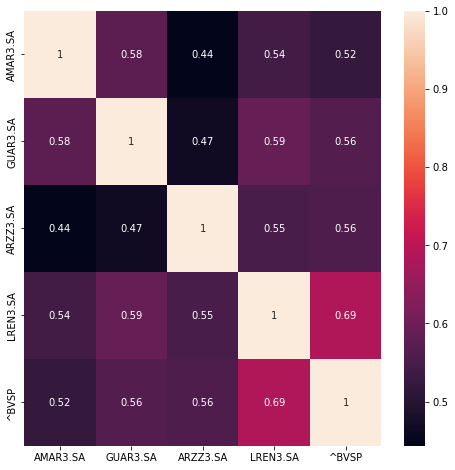

In [34]:
plt.figure(figsize=(8,8))
sns.heatmap(taxas_retorno.corr(), annot=True);

Percebemos que há um relativo equilíbrio na correlação das ações, sendo a Arezzo a menos afetada em caso de variação das outras. Ela também foi o ativo de maior correlação com o índice Bovespa, talvez pelo desempenho que teve a partir de março de 2020.

## Montando uma Carteira de Ativos

Podemos verificar como uma carteira que contenha um conjunto de ações se comporta no decorrer do tempo, através da média das taxas de retorno de cada uma delas. Isso indicará a performance geral da carteira, e pode ser feito usando uma propriedade do `DataFrame`: ao fazermos uma operação aritmética no objeto, ele realiza essa operação em cada um dos elementos da matriz. É possível, também, filtrar cada uma das colunas do `DataFrame`, isolando as informações de uma ação específica.

Sendo assim, ao fazermos a soma de cada uma das ações e dividirmos pelo total de ações, teremos uma nova coluna (`CARTEIRA`) com a média da taxa de retorno diária do conjunto de ações, como representado abaixo:



In [36]:
taxas_retorno_date["CARTEIRA"] = (taxas_retorno_date['AMAR3.SA'] + taxas_retorno_date['GUAR3.SA'] + 
                                   taxas_retorno_date['ARZZ3.SA'] + taxas_retorno_date['LREN3.SA']  )/4
taxas_retorno_date

,Date,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP,CARTEIRA
0,2015-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2015-01-05,-0.007610,-0.032159,-0.031836,-0.028193,-0.020724,-0.024949
2,2015-01-06,-0.063798,-0.003286,-0.019763,0.011453,0.010134,-0.018848
3,2015-01-07,0.018336,0.018190,0.010132,0.016872,0.030003,0.015882
4,2015-01-08,-0.010961,-0.014778,-0.004850,0.001185,0.009657,-0.007351
...,...,...,...,...,...,...,...
1908,2022-09-05,0.000000,0.037134,0.004727,0.010062,0.012006,0.012981
1909,2022-09-06,-0.057629,-0.004938,-0.017841,-0.035475,-0.021977,-0.028971
1910,2022-09-08,0.029230,0.024451,0.006416,-0.000384,0.001384,0.014928
1911,2022-09-09,0.052116,0.021979,0.009709,0.031400,0.021457,0.028801


Temos agora a possibilidade de comparar a performance da carteira com o Índice Bovespa, selecionando as colunas `Data`, `CARTEIRA` e `^BVSP` do nosso conjunto de dados:

In [38]:
taxas_retorno_port = taxas_retorno_date.filter(["Date", "CARTEIRA", '^BVSP'])
taxas_retorno_port

,Date,CARTEIRA,^BVSP
0,2015-01-02,0.000000,0.000000
1,2015-01-05,-0.024949,-0.020724
2,2015-01-06,-0.018848,0.010134
3,2015-01-07,0.015882,0.030003
4,2015-01-08,-0.007351,0.009657
...,...,...,...
1908,2022-09-05,0.012981,0.012006
1909,2022-09-06,-0.028971,-0.021977
1910,2022-09-08,0.014928,0.001384
1911,2022-09-09,0.028801,0.021457


E a representação gráfica fica conforme abaixo:

In [40]:
figuraComparacao = px.line(title = 'Comparação de retorno Carteira x Bovespa')
for i in taxas_retorno_port.columns[1:]:
  figuraComparacao.add_scatter(x = taxas_retorno_port["Date"] ,y = taxas_retorno_port[i], name = i)
figuraComparacao.add_hline(y = taxas_retorno_port['CARTEIRA'].mean(), line_color="green", line_dash="dot", )
figuraComparacao.show()

Percebemos que a carteira teve uma performance similar ao índice até o período de março de 2020, que foi quando a pandemia do Covid 19 começou a impactar os negócios no Brasil. A partir daí, temos uma performance da carteira um pouco melhor do que o índice, puxado, provavelmente, pelo desempenho da Arezzo. Podemos agora analisar o índice de correlação entre a carteira e o índice:

In [42]:
taxas_retorno_port_corr = taxas_retorno_date.filter(["CARTEIRA", "^BVSP"])
taxas_retorno_port_corr

,CARTEIRA,^BVSP
0,0.000000,0.000000
1,-0.024949,-0.020724
2,-0.018848,0.010134
3,0.015882,0.030003
4,-0.007351,0.009657
...,...,...
1908,0.012981,0.012006
1909,-0.028971,-0.021977
1910,0.014928,0.001384
1911,0.028801,0.021457


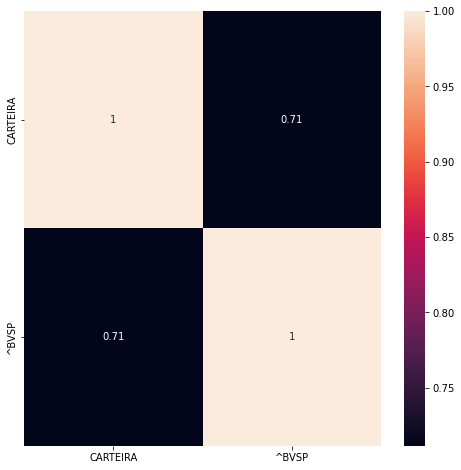

In [44]:
plt.figure(figsize=(8,8))
sns.heatmap(taxas_retorno_port_corr.corr(), annot=True);

Com os dados de retorno das ações em mãos, podemos checar como é a distribuição de cada um dos itens da carteira:

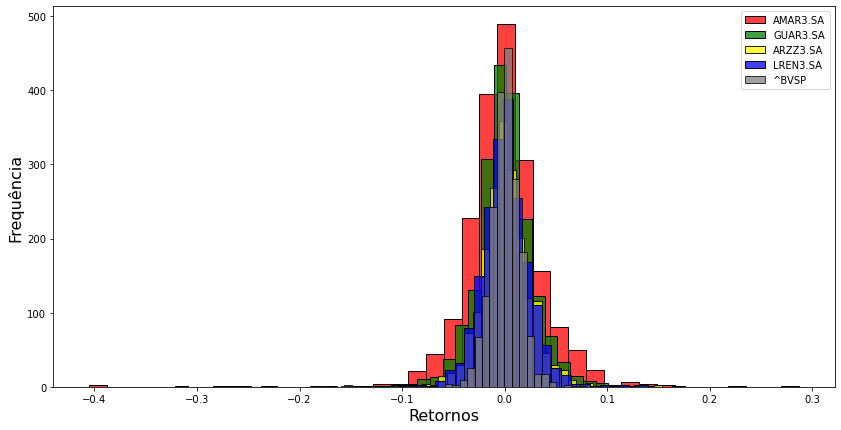

In [45]:
fig, ax = plt.subplots(figsize=(14,7))
ax = sns.histplot(taxas_retorno_date['AMAR3.SA'], bins=40, label='AMAR3.SA', color = 'red')
ax = sns.histplot(taxas_retorno_date['GUAR3.SA'], bins=40, label='GUAR3.SA', color='green')
ax = sns.histplot(taxas_retorno_date['ARZZ3.SA'], bins=40, label='ARZZ3.SA', color='yellow')
ax = sns.histplot(taxas_retorno_date['LREN3.SA'], bins=40, label='LREN3.SA', color='blue')
ax = sns.histplot(taxas_retorno_date['^BVSP'], bins=40, label='^BVSP', color='gray')
ax.set_xlabel("Retornos",fontsize=16)
ax.set_ylabel("Frequência",fontsize=16)
plt.legend()